## This Notebook contains the two best trained models for MLP and SVM 

In [3]:
# Import Libraries
#libraries required

import random
import time

import pandas as pd
import numpy as np
import pickle

import scipy
from scipy.stats import boxcox

import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import radviz

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import skorch
from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping, EpochScoring

In [4]:
# Load test data X and Y from pickle files
with open('X_test_scaled.pkl', 'rb') as f:
    X_test_scaled_loaded = pickle.load(f)

with open('y_test_scaled.pkl', 'rb') as f:
    y_test_scaled_loaded = pickle.load(f)


#### MLP

In [5]:
#Final mlp model architecture 

# Parameters
epochs = 100
input_size = 12 
hidden = 100  
lr = 0.01
criterion = nn.CrossEntropyLoss
activation = F.relu
num_classes = 2               
dropout = 0.3
batch_size = 32
weight_decay = 1e-4
optimizer=optim.Adam

class final_mlp_scaled(nn.Module):
    def __init__(self, input_size=input_size, hidden=hidden, output_size=num_classes, dropout=dropout, activation=activation):
        super(final_mlp_scaled, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.activation = activation
        self.fc1 = nn.Linear(input_size, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, hidden)
        self.output = nn.Linear(hidden, output_size)

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.activation(self.fc2(x))
        x = self.dropout(x)
        x = self.activation(self.fc3(x))
        x = self.dropout(x)
        x = F.softmax(self.output(x), dim=-1)

        return x


In [6]:
#the best mlp model from file
with open('final_mlp_model_scaled.pkl', 'rb') as f:
    mlp_model = pickle.load(f)


In [7]:
print("Accuracy on test data")
accuracy_score(y_test_scaled_loaded, mlp_model.predict(X_test_scaled_loaded)) * 100

Accuracy on test data


86.8

In [8]:
#classification report for mlp
print(classification_report(y_test_scaled_loaded,mlp_model.predict(X_test_scaled_loaded)))



              precision    recall  f1-score   support

           0       0.90      0.82      0.86       240
           1       0.84      0.92      0.88       260

    accuracy                           0.87       500
   macro avg       0.87      0.87      0.87       500
weighted avg       0.87      0.87      0.87       500



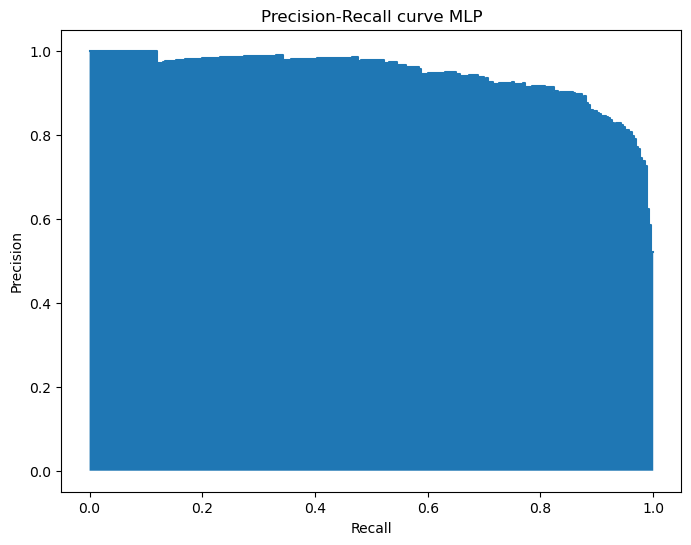

In [9]:
#Precision-recall curve
#Reference [15]: https://www.statology.org/precision-recall-curve-python/
#predicted probabilities for the positive class
y_scores = mlp_model.predict_proba(X_test_scaled_loaded)[:, 1]

# Computing precision and recall
precision, recall, _ = precision_recall_curve(y_test_scaled_loaded, y_scores)

# Computing average precision score
average_precision = average_precision_score(y_test_scaled_loaded, y_scores)

plt.figure(figsize=(8, 6))
plt.step(recall, precision, where='post')
plt.fill_between(recall, precision, step='post')
plt.xlabel('Recall')
plt.ylabel('Precision')

plt.title('Precision-Recall curve MLP')
average_precision
plt.show()





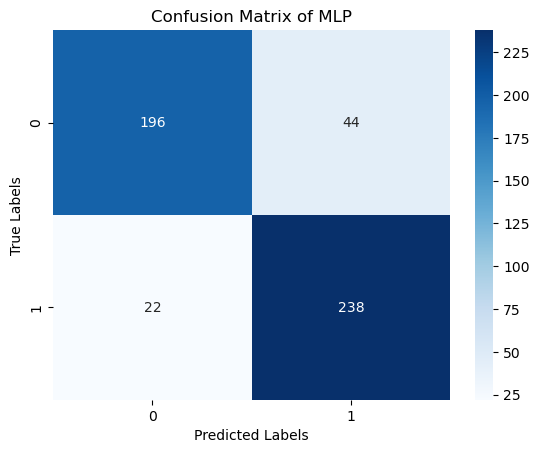

In [10]:
# Generate the confusion matrix
sns.heatmap(confusion_matrix(y_test_scaled_loaded, mlp_model.predict(X_test_scaled_loaded)), annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix of MLP')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

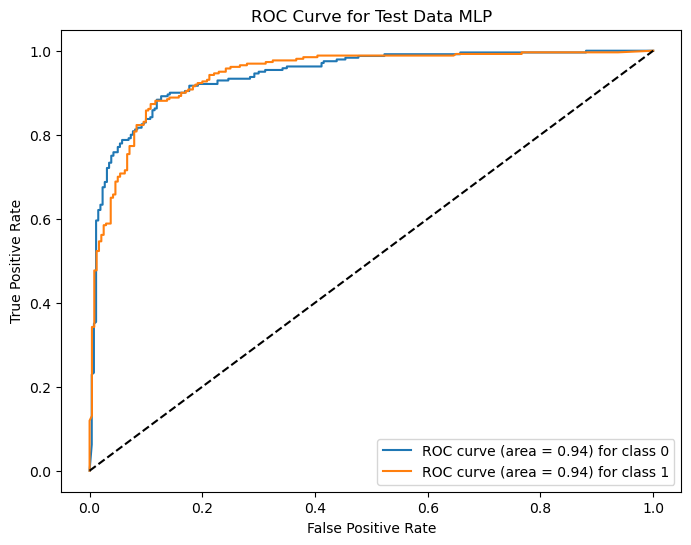

In [11]:
#Reference [12]: https://www.projectpro.io/recipes/plot-roc-curve-in-python

#ROC Curve

# Get predicted probabilities for both classes
y_probs_test = mlp_model.predict_proba(X_test_scaled_loaded)

# Compute ROC curve and ROC area for class 0
false_positive_rate0, true_positive_rate0, _ = roc_curve(y_test_scaled_loaded, y_probs_test[:, 0], pos_label=0)
roc_auc0 = auc(false_positive_rate0, true_positive_rate0)

# Compute ROC curve and ROC area for class 1
false_positive_rate1, true_positive_rate1, _ = roc_curve(y_test_scaled_loaded, y_probs_test[:, 1], pos_label=1)
roc_auc1 = auc(false_positive_rate1, true_positive_rate1)

# Plotting ROC curve
plt.figure(figsize=(8, 6))
plt.plot(false_positive_rate0, true_positive_rate0, label=f'ROC curve (area = {roc_auc0:.2f}) for class 0')
plt.plot(false_positive_rate1, true_positive_rate1, label=f'ROC curve (area = {roc_auc1:.2f}) for class 1')

plt.plot([0, 1], [0, 1], 'k--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Test Data MLP')
plt.legend(loc="lower right")
plt.show()




#### SVM

In [12]:
# Load the trained SVM model from the pickle file
with open('final_svm_model.pkl', 'rb') as file:
    svm_model = pickle.load(file)



In [13]:
# Predict on the loaded test data
y_pred_test = svm_model.predict(X_test_scaled_loaded)

In [14]:
# Calculate accuracy on the loaded test data
print(f"Accuracy on test data")
accuracy_score(y_test_scaled_loaded, y_pred_test) * 100

Accuracy on test data


87.2

In [15]:
#classification report
print(classification_report(y_test_scaled_loaded, y_pred_test))


              precision    recall  f1-score   support

           0       0.90      0.82      0.86       240
           1       0.85      0.92      0.88       260

    accuracy                           0.87       500
   macro avg       0.88      0.87      0.87       500
weighted avg       0.87      0.87      0.87       500



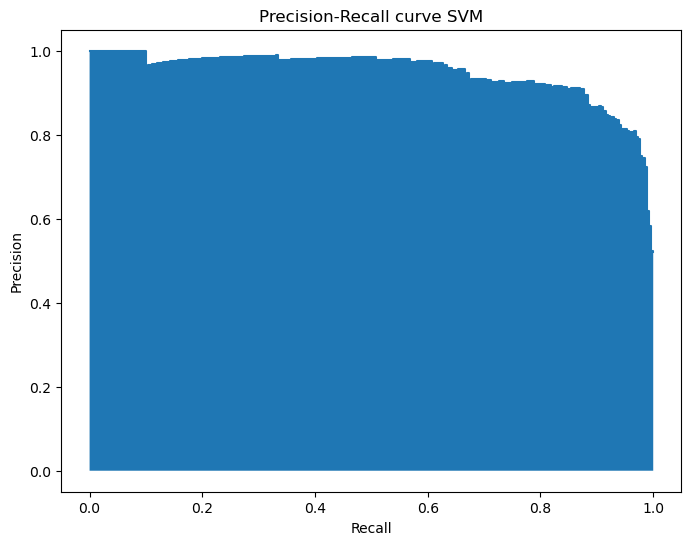

In [16]:
#Precision Recall curve 
#calculating precision and recall
precision, recall, _ = precision_recall_curve(y_test_scaled_loaded, svm_model.decision_function(X_test_scaled_loaded))

#Calculating average precision score
average_precision = average_precision_score(y_test_scaled_loaded, svm_model.decision_function(X_test_scaled_loaded))

# Plot
plt.figure(figsize=(8, 6))
plt.step(recall, precision, where='post')
plt.fill_between(recall, precision, step='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve SVM')
average_precision
plt.show()

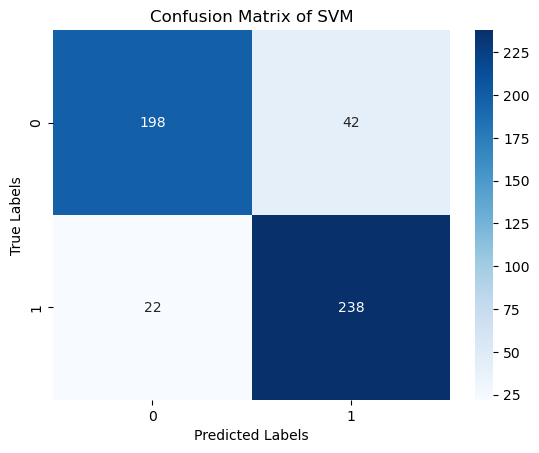

In [17]:
# Compute and display confusion matrix
sns.heatmap(confusion_matrix(y_test_scaled_loaded, svm_model.predict(X_test_scaled_loaded)), annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix of SVM')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

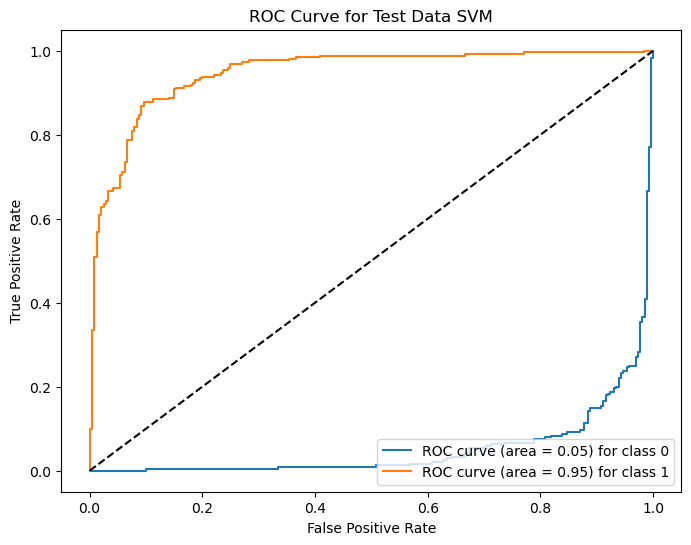

In [18]:
#ROC Curve
#Reference [12]: https://www.projectpro.io/recipes/plot-roc-curve-in-python

# Predict probabilities on the loaded test data
y_probs_test = svm_model.decision_function(X_test_scaled_loaded)

# Computing ROC curve and ROC area for class 0
false_positive_rate0, true_positive_rate0, _ = roc_curve(y_test_scaled_loaded, y_probs_test, pos_label=0)
roc_auc0 = auc(false_positive_rate0, true_positive_rate0)

# Computing ROC curve and ROC area for class 1
false_positive_rate1, true_positive_rate1, _ = roc_curve(y_test_scaled_loaded, y_probs_test, pos_label=1)
roc_auc1 = auc(false_positive_rate1, true_positive_rate1)
plt.figure(figsize=(8, 6))
plt.plot(false_positive_rate0, true_positive_rate0, label=f'ROC curve (area = {roc_auc0:.2f}) for class 0')
plt.plot(false_positive_rate1, true_positive_rate1, label=f'ROC curve (area = {roc_auc1:.2f}) for class 1')

plt.plot([0, 1], [0, 1], 'k--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Test Data SVM')
plt.legend(loc="lower right")
plt.show()
